In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [125]:
# 选择设备
# GPU usage #########################################
# dtype = torch.FloatTensor # uncomment if you are using CPU
dtype = torch.cuda.FloatTensor # uncomment if you are using GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [126]:
# 构建神经网络
class Classifier(nn.Module):
    # Sequential的作用就是连接模型的功能，使代码看起来更加整洁
    def __init__(self, N_input, N_hidde, N_output, learning_rate):
        super().__init__()
        # 定义网络的结构
        self.model = nn.Sequential(
            nn.Linear(N_input, N_hidde), # 输入层到隐藏层
            nn.Sigmoid(), # 激活函数
            nn.Linear(N_hidde, N_output), # 隐藏层到输出层
            nn.Sigmoid() # 激活函数
        ).type(dtype).to(device)
        
        # 定义损失函数
        self.loss_fun = nn.MSELoss()
        # 定义优化器
        self.optimiser = torch.optim.SGD(self.parameters(), lr=learning_rate) # 随机梯度下降法

        # 记录损失函数
        self.counter = 0 # 训练次数
        self.progress = [] # 损失函数值

    def forward(self, x):
        # 前向传播
        x = self.model(x)
        return x
    
    def NN_train(self, inputs_list, targets_list):
        '''
            训练网络分为两步：
            1、给定训练样本计算输出
            2、将计算得到的输出与设置的标准输出做对比，得到误差函数指导网络权重更新
        '''
        # 清空梯度
        self.optimiser.zero_grad()
        # 前向传播
        outputs = self.model(inputs_list)
        # 计算损失函数
        loss = self.loss_fun(outputs, targets_list)
        # 反向传播
        loss.backward()
        # 更新参数
        self.optimiser.step()

        # 记录损失函数
        self.counter += 1
        # 记录损失函数
        if self.counter%100==0:
            self.progress.append(loss.item())
        pass

    def plot_progress(self):
        # 画出损失函数
        # print(self.progress)
        plt.ion()
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0,0.25), figsize=(16,8), alpha=0.8, marker='.', grid=True, yticks=(0, 0.125, 0.25))
        plt.show()

In [127]:
batch_size = 20
# 数据集
# 设置数据集
trainset = datasets.MNIST(root='./data',
                        train=True, 
                        download=True, 
                        transform=transforms.ToTensor())

testset = datasets.MNIST(root='./data', 
                         train=False, 
                         download=True, 
                         transform=transforms.ToTensor())

# 载入数据集
train_data_loader = torch.utils.data.DataLoader(
        dataset=trainset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True)

test_data_loader = torch.utils.data.DataLoader(
        dataset=testset,
        batch_size=1000,
        shuffle=False,
        drop_last=False)

In [128]:
images, labels = next(iter(train_data_loader))
print(images.shape)
print(F.one_hot(labels, num_classes=10).shape)

images, labels = next(iter(test_data_loader))
print(images.shape)
print(F.one_hot(labels, num_classes=10).shape)

torch.Size([20, 1, 28, 28])
torch.Size([20, 10])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 10])


In [129]:
 # 给定输入层，隐藏层，输出层的节点数量
input_nodes = 784 # 28*28
hidden_nodes = 200
output_nodes = 10

# 给定学习率
learning_rate = 0.01

# 给定数据集训练次数
epochs = 100

In [130]:
FNN = Classifier(input_nodes, hidden_nodes, output_nodes, learning_rate)

In [131]:
print("======= 开始训练 =======\n")

for e in range(epochs):
    if e%1==0:    
        print("\r", "学习进度：{:.3f} %".format(e*100/epochs), end='', flush=True)

        for i, data in enumerate(train_data_loader, 0):
            inputs, labels = data
            # 将数据转换为一维向量
            inputs = inputs.view(-1, 28*28).type(dtype).to(device)
            # 将标签转换为one-hot编码
            targets = F.one_hot(labels, num_classes=10).type(dtype).to(device)
            # 训练网络
            FNN.NN_train(inputs, targets)
            
print("\n======= 训练完成 =======\n")

======= 开始训练 =======

 学习进度：99.000 %
======= 训练完成 =======



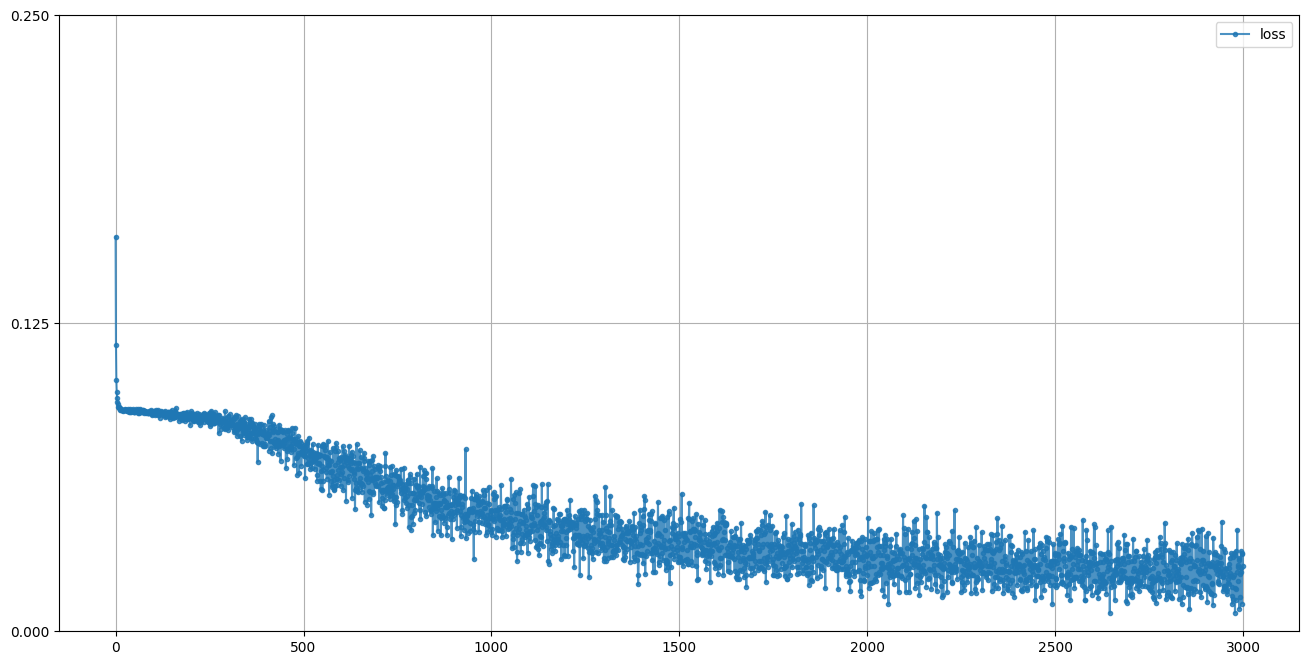

In [132]:
# 画出损失函数
FNN.plot_progress()

In [133]:
FNN.eval()
# 测试网络
correct = 0
total = 0
with torch.no_grad():  # 测试时不需要计算梯度
    for data in test_data_loader:
        inputs, labels = data
        inputs = inputs.view(-1, 28*28).type(dtype).to(device)
        labels = labels.to(device)
        outputs = FNN(inputs)
        _, predicted = torch.max(outputs.data, 1)  # 找到概率最大的下标
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # 预测正确的数目

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


Accuracy of the network on the 10000 test images: 88 %


In [134]:
# 查看模型参数的概览
print("模型参数概览：")
for name, param in FNN.named_parameters():
    print(f"参数名称: {name}, 形状: {param.shape}")

模型参数概览：
参数名称: model.0.weight, 形状: torch.Size([200, 784])
参数名称: model.0.bias, 形状: torch.Size([200])
参数名称: model.2.weight, 形状: torch.Size([10, 200])
参数名称: model.2.bias, 形状: torch.Size([10])
